<a href="https://colab.research.google.com/github/maxmatical/fast.ai/blob/master/Gradient_Accumulation_tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
!pip install git+https://github.com/fastai/fastai.git
!pip install efficientnet-pytorch

In [2]:
# Set up environment and download course-v3
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [3]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from fastai.callbacks import *
from fastai.utils.show_install import *

show_install()




```text
=== Software === 
python        : 3.6.9
fastai        : 1.0.61.dev0
fastprogress  : 0.2.2
torch         : 1.3.1
nvidia driver : 418.67
torch cuda    : 10.1.243 / is available
torch cudnn   : 7603 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 15079MB | Tesla T4

=== Environment === 
platform      : Linux-4.14.137+-x86_64-with-Ubuntu-18.04-bionic
distro        : #1 SMP Thu Aug 8 02:47:02 PDT 2019
conda env     : Unknown
python        : /usr/bin/python3
sys.path      : 
/env/python
/usr/lib/python36.zip
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload
/usr/local/lib/python3.6/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.6/dist-packages/IPython/extensions
/root/.ipython
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.

Optional package(s) to enhance the diagnostics can be installed with:
pip install distro
Once installed, re-ru

In [4]:
path = untar_data(URLs.IMAGENETTE_160)

In [0]:
bs = 32
data = ImageDataBunch.from_folder(path, ds_tfms=get_transforms(), size=224, bs=bs, valid_pct = 0.2).normalize(imagenet_stats)



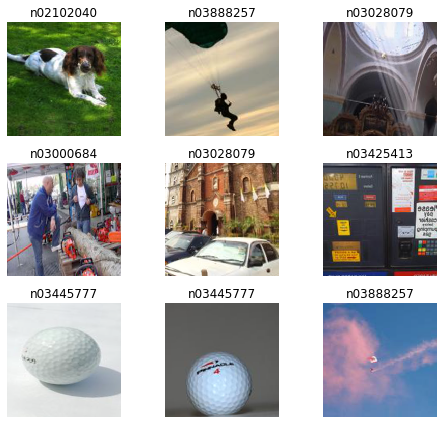

In [16]:
data.show_batch(rows=3, figsize=(7,6))

# Gradient Accumulation

In [0]:
# class GradAccumCallback(Callback):
#     count = 0
#     run_after=MixedPrecision
#     def __init__(self, n_steps):
#         self.n_steps = n_steps
#     def after_backward(self):
#         self.count += 1
#         if (self.count % self.n_steps) == 0:
#             pass
#         else:
#             raise CancelBatchException()

from fastai.basic_train import LearnerCallback
from fastai.basic_train import Learner

In [0]:

class GradientAccumulator(LearnerCallback):
    """Accumulates gradients over N iterations
    Usage:
    accumulator = partial(GradientAccumulator, num_iterations=100)
    learn = create_cnn(data, models.resnet18, callback_fns = [accumulator])
    """
    def __init__(self, learn: Learner, num_iterations: int = 4, disable_callback: bool = False):
        """
        :param num_iterations: Accumulate gradients over `num_iterations` iterations before taking an optimizer step
        """
        super().__init__(learn)
        self.num_iterations = num_iterations
        self.skipped_last_backprop = False

    def on_backward_end(self, iteration, **kwargs) -> None:
        if (iteration % self.num_iterations != 0) or (iteration == 0):
            self.skipped_last_backprop = True
            return {'skip_step': True, 'skip_zero': True}
        else:
            self.skipped_last_backprop = False

    def on_step_end(self, **kwargs):
        if self.skipped_last_backprop:
            return {'skip_zero': True}

    def on_epoch_end(self, **kwargs) ->bool:
        """Deals with the edge case of an epoch ending"""
        if self.skipped_last_backprop:
            self.learn.opt.step()
            self.learn.opt.zero_grad()

accumulator = partial(GradientAccumulator, num_iterations = 4)

In [17]:
try: 
    learn.destroy()
except:
    print('no learner created')

this Learner object self-destroyed - it still exists, but no longer usable


In [0]:
learn = cnn_learner(data, models.resnet34, loss_func = FlattenedLoss(LabelSmoothingCrossEntropy, axis=-1, reduction = 'sum'),
               metrics = [accuracy], callback_fns=partial(AccumulateScheduler, n_step=5))


# learn = cnn_learner(data, models.resnet18, metrics=accuracy, loss_func=CrossEntropyFlat(reduction='sum'),
#                     callback_fns=[accumulator])

# eps = 1e-4
# learn.opt_func = partial(learn.opt_func, eps=eps)

In [0]:
learn.to_fp16();

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-02
Min loss divided by 10: 1.20E-02


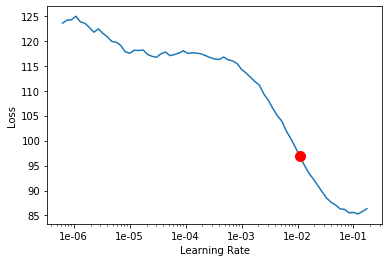

In [20]:
learn.lr_find()
learn.recorder.plot(suggestion = True, skip_end=15)

classifier layer

In [0]:
lr = 1e-2

"""Training without adjusting the momentum"""
# learn.fit(10,lr)


learn.fit_one_cycle(10, 
                    lr, 
                    pct_start = 0.3,
                    callbacks= SaveModelCallback(learn, every='improvement', monitor='accuracy', name='classifier_stage1'))


Unfreeze

In [0]:
try: 
    learn.load('classifier_stage1')
except:
    print('no learner created')
learn.unfreeze();

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion = True, skip_end=15)

In [0]:
lr = 1e-2

"""Training without adjusting the momentum"""
learn.fit_one_cycle(10, 
                    lr, 
                    pct_start = 0.3,
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', 
                                                 name='classifier_stage2')])

# More gradient accumulation methods (With mean reduction) and BN momentum Scaling


In [0]:
class AccumulateOptimWrapper(OptimWrapper):
    def step(self):           pass
    def zero_grad(self):      pass
    def real_step(self):      super().step()
    def real_zero_grad(self): super().zero_grad()
        
def acc_create_opt(self, lr:Floats, wd:Floats=0.):
        "Create optimizer with `lr` learning rate and `wd` weight decay."
        self.opt = AccumulateOptimWrapper.create(self.opt_func, lr, self.layer_groups,
                                         wd=wd, true_wd=self.true_wd, bn_wd=self.bn_wd)
Learner.create_opt = acc_create_opt   

@dataclass
class AccumulateStep(LearnerCallback):
    """
    Does accumlated step every nth step by accumulating gradients
    """
    def __init__(self, learn:Learner, n_step:int = 1):
        super().__init__(learn)
        self.n_step = n_step

    def on_epoch_begin(self, **kwargs):
        "init samples and batches, change optimizer"
        self.acc_batches = 0
        
    def on_batch_begin(self, last_input, last_target, **kwargs):
        "accumulate samples and batches"
        self.acc_batches += 1
        
    def on_backward_end(self, **kwargs):
        "step if number of desired batches accumulated, reset samples"
        if (self.acc_batches % self.n_step) == self.n_step - 1:
            for p in (self.learn.model.parameters()):
                if p.requires_grad: p.grad.div_(self.acc_batches)
    
            self.learn.opt.real_step()
            self.learn.opt.real_zero_grad()
            self.acc_batches = 0
    
    def on_epoch_end(self, **kwargs):
        "step the rest of the accumulated grads"
        if self.acc_batches > 0:
            for p in (self.learn.model.parameters()):
                if p.requires_grad: p.grad.div_(self.acc_batches)
            self.learn.opt.real_step()
            self.learn.opt.real_zero_grad()
            self.acc_batches = 0

In [0]:
def set_BN_momentum(model,momentum=0.1*bs/128): # change from 64 to whatever your desired total batch size is
    for i, (name, layer) in enumerate(model.named_modules()):
        if isinstance(layer, nn.BatchNorm2d) or isinstance(layer, nn.BatchNorm1d):
            layer.momentum = momentum

In [30]:
try: 
    learn.destroy()
except:
    print('no learner created')

this object has been destroyed


In [0]:
learn = cnn_learner(data, models.resnet34, loss_func = FlattenedLoss(LabelSmoothingCrossEntropy, axis=-1),
               metrics = [accuracy])
# learn.clip_grad(1.0); # optional clipping of gradients
set_BN_momentum(learn.model)

learn.to_fp16();

In [32]:
lr = 1e-2/4
learn.fit_one_cycle(6, lr, callbacks = [AccumulateStep(learn, n_step =4)])

epoch,train_loss,valid_loss,accuracy,time
0,0.991367,0.766665,0.978342,01:33
1,0.893927,0.734218,0.967140,01:32


KeyboardInterrupt: ignored